In [1]:
import numpy as np
import pandas as pd
import pickle
import cv2
import os
from os import listdir
from tensorflow import keras
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LSTM
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet152

from keras.regularizers import l2
from keras.layers import Input

from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
import pickle
import lzma


from keras.api._v2.keras import activations

In [2]:
default_image_size = tuple((224,224))
directory_root = 'data'

def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [3]:
image_array_list, label_list = [], []
totalImage = 0
root_dir = listdir('data')
image_folders = ["cloud", "noncloud"]
for image_folder in image_folders :
    image_list = listdir(f"data\\{image_folder}")
    for image in image_list:
        image_name = f"data\\{image_folder}/{image}"
        if isinstance (image_name,str)==True:
            if image_name.endswith(".jpg") == True:
                    image_array_list.append(convert_image_to_array(image_name))
                    label_list.append(image_folder)
                    totalImage=totalImage+1

# Print the total number of images and the number of unique labels
print("Total images loaded:", totalImage)
print("Number of unique labels:", len(np.unique(np.asarray(label_list))))
from sys import getsizeof

# Get the size of the image_array_list in bytes
print("Size of image_list:", getsizeof(image_list))

Total images loaded: 1600
Number of unique labels: 2
Size of image_list: 12728


In [4]:
# create generator
datagen = ImageDataGenerator(rescale=1. /255)
# prepare an iterators for each dataset
directory_root = datagen.flow_from_directory('data', class_mode='binary')

Found 1600 images belonging to 2 classes.


In [5]:
lb = LabelBinarizer()
image_labels = lb.fit_transform(label_list)

In [6]:
image_labels

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [7]:
res = {}
for cl in lb.classes_:
    res.update({cl:lb.transform([cl])[0]})
res

{'cloud': array([0]), 'noncloud': array([1])}

In [8]:
n_classes = len(lb.classes_)
print("total number of classes: ", n_classes)
print(lb.classes_)

total number of classes:  2
['cloud' 'noncloud']


In [41]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np.array(image_array_list), image_labels, test_size=0.3, random_state = 42)

[INFO] Spliting data to train, test


In [10]:
print("x train shape:", x_train.shape)
print("x test shape:", x_test.shape)
print("y train shape:", y_train.shape)
print("x test shape:", y_test.shape)

x train shape: (1120, 224, 224, 3)
x test shape: (480, 224, 224, 3)
y train shape: (1120, 1)
x test shape: (480, 1)


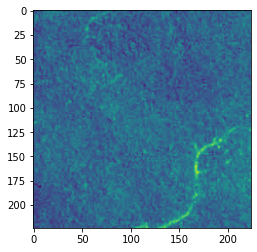

In [11]:
plt.imshow(x_train[1][:,:,0])

In [12]:
x_train = x_train/255.0
x_test = x_test/255.0

In [13]:
scaled_single = x_train[1]
scaled_single

array([[[0.27450982, 0.34117648, 0.2901961 ],
        [0.25882354, 0.3372549 , 0.2901961 ],
        [0.25490198, 0.33333334, 0.28627452],
        ...,
        [0.27058825, 0.34117648, 0.3019608 ],
        [0.27058825, 0.34509805, 0.29803923],
        [0.27450982, 0.3529412 , 0.29411766]],

       [[0.26666668, 0.34117648, 0.2901961 ],
        [0.25490198, 0.3372549 , 0.2901961 ],
        [0.2509804 , 0.32941177, 0.28627452],
        ...,
        [0.26666668, 0.34117648, 0.3019608 ],
        [0.27058825, 0.34509805, 0.3019608 ],
        [0.27450982, 0.3529412 , 0.29803923]],

       [[0.2627451 , 0.34117648, 0.2901961 ],
        [0.25490198, 0.3372549 , 0.2901961 ],
        [0.2509804 , 0.32941177, 0.28627452],
        ...,
        [0.2627451 , 0.34117648, 0.30588236],
        [0.27058825, 0.34509805, 0.30588236],
        [0.2784314 , 0.35686275, 0.30588236]],

       ...,

       [[0.2509804 , 0.33333334, 0.26666668],
        [0.25490198, 0.3254902 , 0.26666668],
        [0.25882354, 0

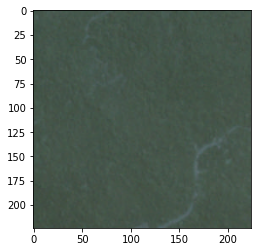

In [14]:
plt.imshow(scaled_single)

Sequential

In [15]:
model_seq = Sequential()
model_seq.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(224, 224, 3), activation='relu',))
model_seq.add(MaxPooling2D(pool_size=(2, 2)))
model_seq.add(Dense(128, activation='relu'))
model_seq.add(Flatten())
model_seq.add(Dense(1, activation='softmax'))

In [16]:
model_seq.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['Accuracy'])

In [17]:
model_seq.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 221, 221, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                                 
 dense (Dense)               (None, 110, 110, 128)     4224      
                                                                 
 flatten (Flatten)           (None, 1548800)           0         
                                                                 
 dense_1 (Dense)             (None, 1)                 1548801   
                                                                 
Total params: 1554593 (5.93 MB)
Trainable params: 1554593 (5.93 MB)
Non-trainable params: 0 (0.00 Byte)
__________________

In [18]:
prediction_fit_seq = model_seq.fit(x_train, y_train, epochs = 50, batch_size=32, verbose=1)

Epoch 1/50
35/35 [==============================] - 26s 715ms/step - loss: 1.4552 - Accuracy: 0.9357
Epoch 2/50
35/35 [==============================] - 25s 709ms/step - loss: 0.2607 - Accuracy: 0.9357
Epoch 3/50
35/35 [==============================] - 25s 717ms/step - loss: 0.2356 - Accuracy: 0.9357
Epoch 4/50
35/35 [==============================] - 25s 703ms/step - loss: 0.2209 - Accuracy: 0.9357
Epoch 5/50
35/35 [==============================] - 25s 708ms/step - loss: 0.2222 - Accuracy: 0.9357
Epoch 6/50
35/35 [==============================] - 25s 699ms/step - loss: 0.2146 - Accuracy: 0.9357
Epoch 7/50
35/35 [==============================] - 24s 700ms/step - loss: 0.2574 - Accuracy: 0.9357
Epoch 8/50
35/35 [==============================] - 25s 707ms/step - loss: 0.2145 - Accuracy: 0.9357
Epoch 9/50
35/35 [==============================] - 24s 698ms/step - loss: 0.2060 - Accuracy: 0.9357
Epoch 10/50
35/35 [==============================] - 25s 707ms/step - loss: 0.1930 - Accura

In [19]:
prediction_seq = model_seq.predict(x_test)

15/15 [==============================] - 4s 230ms/step


In [20]:
y_pred = []

for i in prediction_seq:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

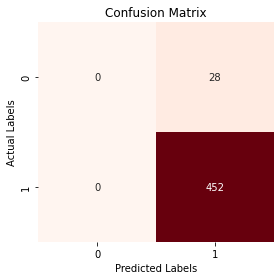

In [21]:
conf_matrix = confusion_matrix(y_true= y_test, y_pred= y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.tight_layout()

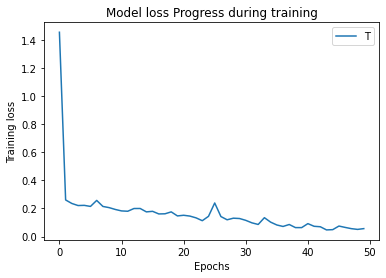

In [22]:
import matplotlib.pyplot as plt

plt.plot(prediction_fit_seq.history['loss'])
plt.title('Model loss Progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend('Training loss')
plt.show()

In [23]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1score)
print(classification_report(y_test, y_pred))

F1 score: 0.913376251788269
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.94      1.00      0.97       452

    accuracy                           0.94       480
   macro avg       0.47      0.50      0.48       480
weighted avg       0.89      0.94      0.91       480



c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

Sequential + Dropout

In [24]:
model_drop = Sequential()
model_drop.add(Conv2D(filters=32, kernel_size=(4,4),input_shape=(224, 224, 3), activation='relu',))
model_drop.add(Dropout(0.2))
model_drop.add(MaxPooling2D(pool_size=(2, 2)))
model_drop.add(Dropout(0.2))
model_drop.add(Dense(128, activation='relu'))
model_drop.add(BatchNormalization())
model_drop.add(Dropout(0.2))
model_drop.add(Dense(64, activation='sigmoid'))
model_drop.add(Dropout(0.2))
model_drop.add(Dense(32, activation='relu'))
model_drop.add(Dropout(0.2))
model_drop.add(Flatten())
model_drop.add(Dense(1, activation='sigmoid'))

In [25]:
model_drop.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['Accuracy'])

In [26]:
model_drop.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 221, 221, 32)      1568      
                                                                 
 dropout (Dropout)           (None, 221, 221, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 110, 110, 32)      0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 110, 110, 32)      0         
                                                                 
 dense_2 (Dense)             (None, 110, 110, 128)     4224      
                                                                 
 batch_normalization (Batch  (None, 110, 110, 128)     512       
 Normalization)                                       

In [27]:
prediction_fit_drop = model_drop.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50, batch_size=32, verbose=1)

Epoch 1/50
35/35 [==============================] - 94s 3s/step - loss: 4.2849 - Accuracy: 0.8938 - val_loss: 0.2352 - val_Accuracy: 0.9417
Epoch 2/50
35/35 [==============================] - 93s 3s/step - loss: 0.7055 - Accuracy: 0.8929 - val_loss: 0.5206 - val_Accuracy: 0.9417
Epoch 3/50
35/35 [==============================] - 94s 3s/step - loss: 0.2475 - Accuracy: 0.9357 - val_loss: 0.4392 - val_Accuracy: 0.9417
Epoch 4/50
35/35 [==============================] - 95s 3s/step - loss: 0.2538 - Accuracy: 0.9366 - val_loss: 0.4381 - val_Accuracy: 0.9417
Epoch 5/50
35/35 [==============================] - 94s 3s/step - loss: 0.2389 - Accuracy: 0.9348 - val_loss: 0.3936 - val_Accuracy: 0.9417
Epoch 6/50
35/35 [==============================] - 94s 3s/step - loss: 0.2519 - Accuracy: 0.9357 - val_loss: 0.4780 - val_Accuracy: 0.9417
Epoch 7/50
35/35 [==============================] - 94s 3s/step - loss: 0.2198 - Accuracy: 0.9384 - val_loss: 0.4650 - val_Accuracy: 0.9417
Epoch 8/50
35/35 [==

In [28]:
prediction_drop = model_drop.predict(x_test)

15/15 [==============================] - 6s 400ms/step


In [29]:
y_pred = []

for i in prediction_drop:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

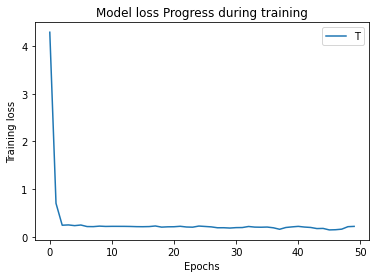

In [30]:
import matplotlib.pyplot as plt

plt.plot(prediction_fit_drop.history['loss'])
plt.title('Model loss Progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend('Training loss')
plt.show()

In [31]:
model_drop.metrics_names

['loss', 'Accuracy']

In [32]:
losses = pd.DataFrame(prediction_fit_drop.history)

In [33]:
losses.columns

Index(['loss', 'Accuracy', 'val_loss', 'val_Accuracy'], dtype='object')

In [34]:
losses.head()

,loss,Accuracy,val_loss,val_Accuracy
0,4.284898,0.893750,0.235163,0.941667
1,0.705536,0.892857,0.520635,0.941667
2,0.247459,0.935714,0.439217,0.941667
3,0.253824,0.936607,0.438071,0.941667
4,0.238884,0.934821,0.393624,0.941667


<AxesSubplot:>

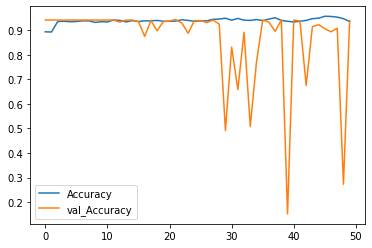

In [35]:
losses[['Accuracy','val_Accuracy']].plot()

In [36]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1score)
print(classification_report(y_test, y_pred))

F1 score: 0.9123344074471895
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.94      1.00      0.97       452

    accuracy                           0.94       480
   macro avg       0.47      0.50      0.48       480
weighted avg       0.89      0.94      0.91       480



LeNet-5

In [37]:
lenet = Sequential()
lenet.add(Conv2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(224, 224, 3)))
lenet.add(MaxPooling2D(strides=2))
lenet.add(Conv2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu'))
lenet.add(MaxPooling2D(strides=2))
lenet.add(Flatten())
lenet.add(Dense(256, activation='relu'))
lenet.add(Dense(84, activation='relu'))
lenet.add(Dense(1, activation='sigmoid'))

In [38]:
lenet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 48)      38448     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 48)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 139968)            0         
                                                                 
 dense_6 (Dense)             (None, 256)              

In [39]:
lenet.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['Accuracy'])

In [40]:
prediction_fit_lenet = lenet.fit(x_train, y_train, validation_data=(x_test, y_test), epochs = 50, batch_size=32, verbose=1)

Epoch 1/50
35/35 [==============================] - 71s 2s/step - loss: 0.3309 - Accuracy: 0.9357 - val_loss: 0.2135 - val_Accuracy: 0.9417
Epoch 2/50
35/35 [==============================] - 70s 2s/step - loss: 0.2743 - Accuracy: 0.9357 - val_loss: 0.5377 - val_Accuracy: 0.9417
Epoch 3/50
35/35 [==============================] - 70s 2s/step - loss: 0.2602 - Accuracy: 0.9357 - val_loss: 0.2445 - val_Accuracy: 0.9417
Epoch 4/50
35/35 [==============================] - 69s 2s/step - loss: 0.2507 - Accuracy: 0.9357 - val_loss: 0.2373 - val_Accuracy: 0.9417
Epoch 5/50
35/35 [==============================] - 70s 2s/step - loss: 0.2441 - Accuracy: 0.9357 - val_loss: 0.2038 - val_Accuracy: 0.9417
Epoch 6/50
35/35 [==============================] - 69s 2s/step - loss: 0.2466 - Accuracy: 0.9348 - val_loss: 0.2093 - val_Accuracy: 0.9417
Epoch 7/50
35/35 [==============================] - 69s 2s/step - loss: 0.2280 - Accuracy: 0.9357 - val_loss: 0.2010 - val_Accuracy: 0.9417
Epoch 8/50
35/35 [==

In [41]:
prediction_lenet = lenet.predict(x_test)

15/15 [==============================] - 6s 384ms/step


In [42]:
y_pred = []

for i in prediction_lenet:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [43]:
("%.4f" % (accuracy_score(y_test, y_pred)*100))

'94.1667'

In [44]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1score)
print(classification_report(y_test, y_pred))

F1 score: 0.913376251788269
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.94      1.00      0.97       452

    accuracy                           0.94       480
   macro avg       0.47      0.50      0.48       480
weighted avg       0.89      0.94      0.91       480



c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

In [45]:
losses = pd.DataFrame(prediction_fit_lenet.history)

<AxesSubplot:>

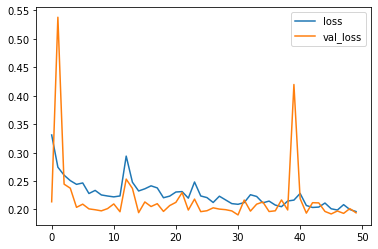

In [46]:
losses[['loss','val_loss']].plot()

VGG19

In [48]:
VGG19_MODEL = keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling="max"
)

In [49]:
y=Flatten()(VGG19_MODEL.output)

In [50]:
final = Dense(1, activation = 'sigmoid')(y)
VGG19 = Model(VGG19_MODEL.inputs, final)

In [51]:
VGG19.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [52]:
VGG19.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['Accuracy'])

In [54]:
prediction_fit_vgg19 = VGG19.fit(x_train, y_train, epochs = 50, batch_size=32, verbose=1)

Epoch 1/50
35/35 [==============================] - 871s 25s/step - loss: 0.2411 - Accuracy: 0.9357
Epoch 2/50
35/35 [==============================] - 862s 25s/step - loss: 0.2414 - Accuracy: 0.9357
Epoch 3/50
35/35 [==============================] - 864s 25s/step - loss: 0.2418 - Accuracy: 0.9357
Epoch 4/50
35/35 [==============================] - 863s 25s/step - loss: 0.2404 - Accuracy: 0.9357
Epoch 5/50
35/35 [==============================] - 863s 25s/step - loss: 0.2416 - Accuracy: 0.9357
Epoch 6/50
35/35 [==============================] - 861s 25s/step - loss: 0.2407 - Accuracy: 0.9357
Epoch 7/50
35/35 [==============================] - 864s 25s/step - loss: 0.2412 - Accuracy: 0.9357
Epoch 8/50
35/35 [==============================] - 865s 25s/step - loss: 0.2413 - Accuracy: 0.9357
Epoch 9/50
35/35 [==============================] - 860s 25s/step - loss: 0.2409 - Accuracy: 0.9357
Epoch 10/50
35/35 [==============================] - 863s 25s/step - loss: 0.2393 - Accuracy: 0.9357

In [55]:
prediction_vgg19 = VGG19.predict(x_test)

15/15 [==============================] - 109s 7s/step


In [56]:
y_pred = []

for i in prediction_vgg19:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

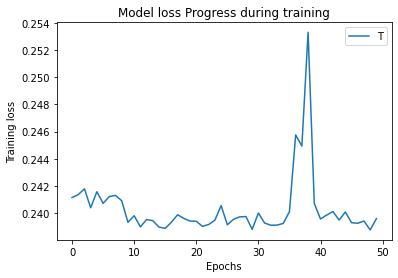

In [57]:
import matplotlib.pyplot as plt

plt.plot(prediction_fit_vgg19.history['loss'])
plt.title('Model loss Progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend('Training loss')
plt.show()

In [58]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1score)
print(classification_report(y_test, y_pred))

F1 score: 0.913376251788269
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.94      1.00      0.97       452

    accuracy                           0.94       480
   macro avg       0.47      0.50      0.48       480
weighted avg       0.89      0.94      0.91       480



c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

DenseNet21

In [15]:
DenseNet121 = keras.applications.vgg19.VGG19(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(224,224,3),
    pooling="max"
)

In [16]:
y=Flatten()(DenseNet121.output)

In [17]:
final = Dense(1, activation = 'sigmoid')(y)
DenseNet = Model(DenseNet121.inputs, final)

In [18]:
DenseNet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [19]:
DenseNet.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['Accuracy'])

In [20]:
prediction_fit_densenet = DenseNet.fit(x_train, y_train, epochs = 50, batch_size=32, verbose=1)

Epoch 1/50
35/35 [==============================] - 925s 26s/step - loss: 0.4897 - Accuracy: 0.9125
Epoch 2/50
35/35 [==============================] - 879s 25s/step - loss: 0.2570 - Accuracy: 0.9357
Epoch 3/50
35/35 [==============================] - 865s 25s/step - loss: 0.2460 - Accuracy: 0.9357
Epoch 4/50
35/35 [==============================] - 867s 25s/step - loss: 0.2432 - Accuracy: 0.9357
Epoch 5/50
35/35 [==============================] - 864s 25s/step - loss: 0.2423 - Accuracy: 0.9357
Epoch 6/50
35/35 [==============================] - 862s 25s/step - loss: 0.2409 - Accuracy: 0.9357
Epoch 7/50
35/35 [==============================] - 877s 25s/step - loss: 0.2415 - Accuracy: 0.9357
Epoch 8/50
35/35 [==============================] - 983s 28s/step - loss: 0.2425 - Accuracy: 0.9357
Epoch 9/50
35/35 [==============================] - 865s 25s/step - loss: 0.2449 - Accuracy: 0.9357
Epoch 10/50
35/35 [==============================] - 864s 25s/step - loss: 0.2416 - Accuracy: 0.9357

In [21]:
prediction_densenet = DenseNet.predict(x_test)

15/15 [==============================] - 107s 7s/step


In [22]:
y_pred = []

for i in prediction_densenet:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

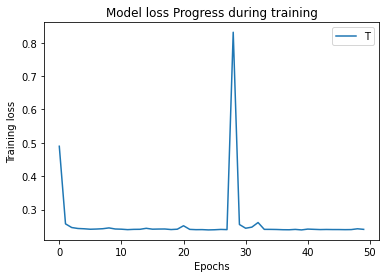

In [23]:
import matplotlib.pyplot as plt

plt.plot(prediction_fit_densenet.history['loss'])
plt.title('Model loss Progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend('Training loss')
plt.show()

In [24]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1score)
print(classification_report(y_test, y_pred))

F1 score: 0.913376251788269
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.94      1.00      0.97       452

    accuracy                           0.94       480
   macro avg       0.47      0.50      0.48       480
weighted avg       0.89      0.94      0.91       480



c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Harshit\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

RESNET + LSTM

In [25]:
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet152(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=(224, 224, 3),
    pooling='max')

for layer in base_model.layers:
    layer.trainable = False
n_model =   base_model.layers[-1] 

dense_clinical = Dense(224,name='dense_clinical',activation='sigmoid',activity_regularizer=l2(0.001))((base_model.output))

res = tf.keras.layers.Reshape((2,112), input_shape=(None,224))(dense_clinical)
lst=tf.keras.layers.LSTM(50, activation='tanh', input_shape=(2, 112))(res)
dense_layer = tf.keras.layers.Dense(112, activation='relu')(lst)
flat_layer = Flatten(name="Flatten")(dense_layer)
ful = Dense(1, activation='sigmoid')(flat_layer)
model = Model(inputs= input_tensor,outputs= ful)

In [26]:
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['Accuracy'])

In [27]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [42]:
prediction_fit_trf = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 50, batch_size=32, verbose=1)

Epoch 1/50
35/35 [==============================] - 277s 8s/step - loss: 0.2345 - Accuracy: 0.9357 - val_loss: 0.1713 - val_Accuracy: 0.9417
Epoch 2/50
35/35 [==============================] - 286s 8s/step - loss: 0.1654 - Accuracy: 0.9464 - val_loss: 0.1478 - val_Accuracy: 0.9604
Epoch 3/50
35/35 [==============================] - 282s 8s/step - loss: 0.1519 - Accuracy: 0.9616 - val_loss: 0.1391 - val_Accuracy: 0.9688
Epoch 4/50
35/35 [==============================] - 290s 8s/step - loss: 0.1435 - Accuracy: 0.9643 - val_loss: 0.1538 - val_Accuracy: 0.9667
Epoch 5/50
35/35 [==============================] - 285s 8s/step - loss: 0.1270 - Accuracy: 0.9696 - val_loss: 0.1893 - val_Accuracy: 0.9604
Epoch 6/50
35/35 [==============================] - 283s 8s/step - loss: 0.1263 - Accuracy: 0.9705 - val_loss: 0.1375 - val_Accuracy: 0.9750
Epoch 7/50
35/35 [==============================] - 286s 8s/step - loss: 0.1151 - Accuracy: 0.9714 - val_loss: 0.1288 - val_Accuracy: 0.9708
Epoch 8/50
35

In [43]:
prediction_trf = model.predict(x_test)

15/15 [==============================] - 98s 7s/step


In [44]:
y_pred = []

for i in prediction_trf:
  if i>0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

In [45]:
("%.4f" % (accuracy_score(y_test, y_pred)*100))

'96.0417'

In [46]:
f1score = f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1score)
print("Classification Report: \n", classification_report(y_test, y_pred))

F1 score: 0.9534988543574227
Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.39      0.54        28
           1       0.96      1.00      0.98       452

    accuracy                           0.96       480
   macro avg       0.90      0.69      0.76       480
weighted avg       0.96      0.96      0.95       480



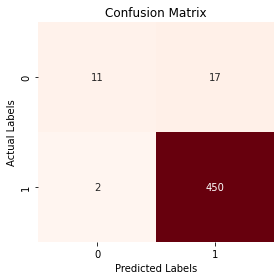

In [47]:
conf_matrix = confusion_matrix(y_true= y_test, y_pred= y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Reds')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
plt.tight_layout()

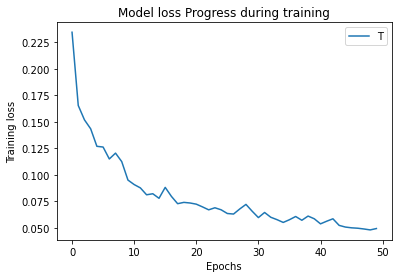

In [48]:
import matplotlib.pyplot as plt

plt.plot(prediction_fit_trf.history['loss'])
plt.title('Model loss Progress during training')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend('Training loss')
plt.show()

In [49]:
losses = pd.DataFrame(prediction_fit_trf.history)

In [50]:
losses.head()

,loss,Accuracy,val_loss,val_Accuracy
0,0.234500,0.935714,0.171340,0.941667
1,0.165448,0.946429,0.147794,0.960417
2,0.151910,0.961607,0.139095,0.968750
3,0.143462,0.964286,0.153822,0.966667
4,0.126971,0.969643,0.189337,0.960417


<AxesSubplot:>

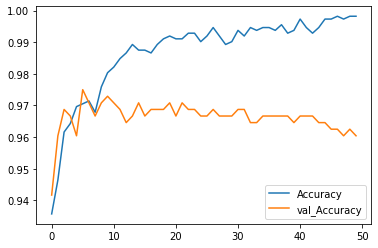

In [51]:
losses[['Accuracy','val_Accuracy']].plot()

In [39]:
pickle.dump(model, lzma.open('model.pickle', 'wb'))